In [120]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
import pandas as pd
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import precision_score

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")

x_train shape: (60000, 28, 28, 1), y_train shape: (60000,)


In [121]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

pca = PCA(n_components=20)
x_train_pca = pca.fit_transform(x_train_flat)
x_test_pca = pca.transform(x_test_flat)

In [122]:
def apply_hog_fixed(images):
    hog_features = []
    for img in images:
        feature, _= hog(img, orientations=9, pixels_per_cell=(8, 8),
                         cells_per_block=(2, 2), visualize=True, channel_axis=2)
        hog_features.append(feature)
    return np.array(hog_features)

hog_features_train = apply_hog_fixed(x_train)
hog_features_test = apply_hog_fixed(x_test)

print(f"HOG Features Train Shape: {hog_features_train.shape}")
print(f"HOG Features Test Shape: {hog_features_test.shape}")

HOG Features Train Shape: (60000, 144)
HOG Features Test Shape: (10000, 144)


## 3.1

In [123]:
scaler = StandardScaler()

scaler.fit(x_train_pca)

x_train_pca_standardized = scaler.transform(x_train_pca)

x_test_pca_standardized = scaler.transform(x_test_pca)


scaler_hog = StandardScaler()
x_train_hog_standardized = scaler_hog.fit_transform(hog_features_train)
x_test_hog_standardized = scaler_hog.transform(hog_features_test)

x_train_combined = np.hstack((x_train_pca_standardized, x_train_hog_standardized))
x_test_combined = np.hstack((x_test_pca_standardized, x_test_hog_standardized))

# variance_threshold = VarianceThreshold(threshold=1)
# x_train_variance = variance_threshold.fit_transform(x_train_combined)
# x_test_variance = variance_threshold.transform(x_test_combined)

# print("Dimensiuni înainte și după Variance Threshold:")
# print(f"Dimensiuni train înainte: {x_train_combined.shape}, după: {x_train_variance.shape}")
# print(f"Dimensiuni test înainte: {x_test_combined.shape}, după: {x_test_variance.shape}")


select_percentile = SelectPercentile(f_classif, percentile=35)
x_train_final = select_percentile.fit_transform(x_train_combined, y_train)
x_test_final = select_percentile.transform(x_test_combined)

print(f"Dimensiuni finale: Train: {x_train_final.shape}, Test: {x_test_final.shape}")



Dimensiuni finale: Train: (60000, 58), Test: (10000, 58)


In [124]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Transformă datele în tensori PyTorch
x_train_tensor = torch.Tensor(x_train_final)
x_test_tensor = torch.Tensor(x_test_final)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

# Creează DataLoader pentru train și test
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [125]:
import torch.nn as nn

# class MLP(nn.Module):
#     def __init__(self, input_size, hidden_sizes, output_size):
#         super(MLP, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_sizes[0])
#         self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
#         self.fc3 = nn.Linear(hidden_sizes[1], output_size)
#         self.relu = nn.ReLU()
#         # self.dropout = nn.Dropout(0.2)

#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         # x = self.dropout(x)
#         x = self.relu(self.fc2(x))
#         # x = self.dropout(x)
#         x = self.fc3(x)
#         return x

class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_sizes, output_size)
        
    def forward(self, x):
        z = self.fc1(x)
        z = self.relu(z)
        z = self.fc2(z)
        return z

# Creează modelul
input_size = x_train_final.shape[1]  # Dimensiunea caracteristicilor
hidden_sizes = 100
output_size = 10  # 10 clase pentru Fashion-MNIST

model = MLP(input_size, hidden_sizes, output_size)



In [126]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [134]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 20
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

for epoch in range(num_epochs):
    # Antrenare
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Testare
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_losses.append(running_loss / len(test_loader))
    test_accuracies.append(correct / total)

    print(f"Epoch {epoch+1}/{num_epochs},\n Train Loss: {train_losses[-1]:.4f},\n Test Loss: {test_losses[-1]:.4f}, "
          f"\nTrain Acc: {train_accuracies[-1]:.4f},\n Test Acc: {test_accuracies[-1]:.4f}")


Epoch 1/20,
 Train Loss: 0.1981,
 Test Loss: 0.3372, 
Train Acc: 0.9266,
 Test Acc: 0.8843
Epoch 2/20,
 Train Loss: 0.1931,
 Test Loss: 0.3620, 
Train Acc: 0.9275,
 Test Acc: 0.8825
Epoch 3/20,
 Train Loss: 0.1882,
 Test Loss: 0.3385, 
Train Acc: 0.9299,
 Test Acc: 0.8891
Epoch 4/20,
 Train Loss: 0.1828,
 Test Loss: 0.3508, 
Train Acc: 0.9325,
 Test Acc: 0.8853
Epoch 5/20,
 Train Loss: 0.1838,
 Test Loss: 0.3504, 
Train Acc: 0.9310,
 Test Acc: 0.8868
Epoch 6/20,
 Train Loss: 0.1796,
 Test Loss: 0.3760, 
Train Acc: 0.9326,
 Test Acc: 0.8846
Epoch 7/20,
 Train Loss: 0.1736,
 Test Loss: 0.3522, 
Train Acc: 0.9353,
 Test Acc: 0.8908
Epoch 8/20,
 Train Loss: 0.1722,
 Test Loss: 0.3464, 
Train Acc: 0.9365,
 Test Acc: 0.8920
Epoch 9/20,
 Train Loss: 0.1662,
 Test Loss: 0.3692, 
Train Acc: 0.9382,
 Test Acc: 0.8868


KeyboardInterrupt: 

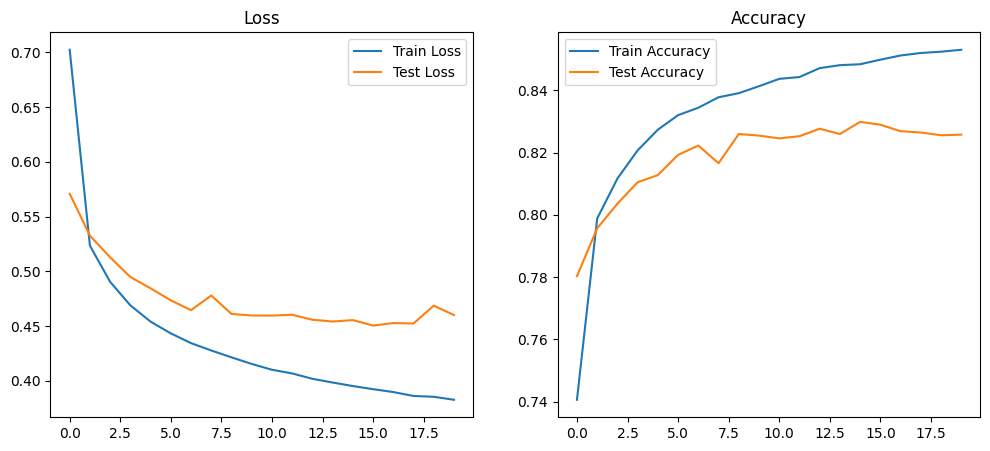

In [128]:
import matplotlib.pyplot as plt

# Curbele de pierdere
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()

# Curbele de acuratețe
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()


In [129]:
# from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# # Preziceri pe setul de test
# model.eval()
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for inputs, labels in test_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1)
#         all_preds.extend(predicted.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# print(classification_report(all_labels, all_preds))
# ConfusionMatrixDisplay.from_predictions(all_labels, all_preds, cmap='Blues')
# plt.show()


## 3.2

In [130]:
import torch.nn as nn

# class MLP(nn.Module):
#     def __init__(self, input_size, hidden_sizes, output_size):
#         super(MLP, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_sizes[0])  # Primul strat: 784 → 256
#         self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])  # Al doilea strat: 256 → 128
#         self.fc3 = nn.Linear(hidden_sizes[1], output_size)  # Strat final: 128 → 10
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.2)

#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.relu(self.fc2(x))
#         x = self.dropout(x)
#         x = self.fc3(x)  # Ultimul strat, fără activare (CrossEntropyLoss aplică softmax)
#         return x

# Inițializarea modelului



import torch
from torch.utils.data import DataLoader, TensorDataset

# Transformare în tensori PyTorch și liniarizare
x_train_tensor = torch.Tensor(x_train.reshape(x_train.shape[0], -1))
x_test_tensor = torch.Tensor(x_test.reshape(x_test.shape[0], -1))
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

# Crearea DataLoader-elor
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


input_size = x_train.shape[1] * x_train.shape[2]  # Dimensiunea imaginilor liniarizate
# hidden_sizes = [256, 128] # 100
# output_size = 10  # Număr de clase pentru Fashion-MNIST

model = MLP(input_size, hidden_sizes, output_size)


In [131]:
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 20
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

for epoch in range(num_epochs):
    # Antrenare
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        # inputs = inputs.view(inputs.size(0), -1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Testare
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), -1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_losses.append(running_loss / len(test_loader))
    test_accuracies.append(correct / total)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, "
          f"Train Acc: {train_accuracies[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}")


Epoch 1/20, Train Loss: 0.5522, Test Loss: 0.4815, Train Acc: 0.8091, Test Acc: 0.8248
Epoch 2/20, Train Loss: 0.4095, Test Loss: 0.4242, Train Acc: 0.8545, Test Acc: 0.8497
Epoch 3/20, Train Loss: 0.3657, Test Loss: 0.3855, Train Acc: 0.8689, Test Acc: 0.8623
Epoch 4/20, Train Loss: 0.3398, Test Loss: 0.3770, Train Acc: 0.8773, Test Acc: 0.8640
Epoch 5/20, Train Loss: 0.3218, Test Loss: 0.3618, Train Acc: 0.8828, Test Acc: 0.8712
Epoch 6/20, Train Loss: 0.3044, Test Loss: 0.3584, Train Acc: 0.8887, Test Acc: 0.8717
Epoch 7/20, Train Loss: 0.2921, Test Loss: 0.3519, Train Acc: 0.8926, Test Acc: 0.8735
Epoch 8/20, Train Loss: 0.2836, Test Loss: 0.3473, Train Acc: 0.8956, Test Acc: 0.8757
Epoch 9/20, Train Loss: 0.2711, Test Loss: 0.3583, Train Acc: 0.9013, Test Acc: 0.8672
Epoch 10/20, Train Loss: 0.2627, Test Loss: 0.3367, Train Acc: 0.9026, Test Acc: 0.8823
Epoch 11/20, Train Loss: 0.2543, Test Loss: 0.3360, Train Acc: 0.9055, Test Acc: 0.8795
Epoch 12/20, Train Loss: 0.2476, Test Los

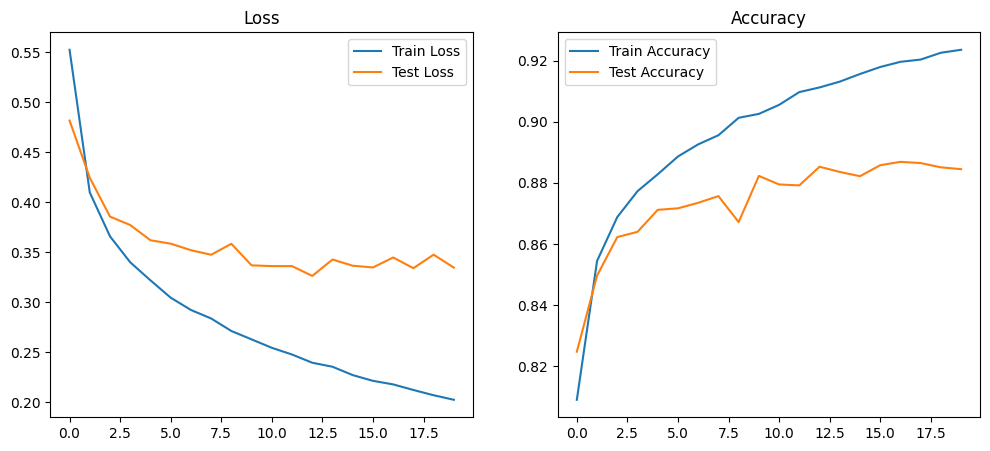

In [132]:
import matplotlib.pyplot as plt

# Curbele de pierdere
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()

# Curbele de acuratețe
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()


## 3.3

In [133]:
# # model = MLP(input_dim, hidden_dim, output_dim)

# # Define the loss function
# criterion = nn.CrossEntropyLoss()

# # Define the optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# X_train_flatten = x_train.reshape(x_train.shape[0], -1)
# X_test_flatten = x_test.reshape(x_test.shape[0], -1)

# # Convert the NumPy arrays to PyTorch tensors
# X_train_tensor = torch.Tensor(X_train_flatten)
# y_train_tensor = torch.LongTensor(y_train)
# X_test_tensor = torch.Tensor(X_test_flatten)
# y_test_tensor = torch.LongTensor(y_test)

# # Create a DataLoader
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('Device:', device)
# model.to(device)

# # Set the model to training mode
# model.train()

# loss_history = []
# loss_history_test = []
# accuracy_history = []
# accuracy_history_test = []

# # Train the model and plot the loss and accuracy for every epoch
# num_epochs = 10

# for epoch in range(num_epochs):
#     running_loss = 0.0
#     running_corrects = 0
#     for inputs, labels in train_loader:
#         inputs = inputs.to(device)
#         labels = labels.to(device)
        
#         # Zero the parameter gradients
#         optimizer.zero_grad()
        
#         # Forward pass
#         inputs = inputs.view(inputs.size(0), -1)
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
        
#         # Backward pass
#         loss.backward()
#         optimizer.step()
        
#         # Compute the loss and accuracy
#         running_loss += loss.item() * inputs.size(0)
#         _, preds = torch.max(outputs, 1)
#         running_corrects += torch.sum(preds == labels.data)
        
#     epoch_loss = running_loss / len(train_loader.dataset)
#     epoch_acc = running_corrects.double() / len(train_loader.dataset)
    
#     loss_history.append(epoch_loss)
#     accuracy_history.append(epoch_acc.item())
    
#     # Evaluate the model on the test set
#     model.eval()
#     with torch.no_grad():
#         inputs = X_test_tensor.to(device)
#         labels = y_test_tensor.to(device)
#         inputs = inputs.view(inputs.size(0), -1)
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         _, preds = torch.max(outputs, 1)
#         epoch_loss_test = loss.item()
#         epoch_acc_test = torch.sum(preds == labels.data).double() / len(labels)
        
#         loss_history_test.append(epoch_loss_test)
#         accuracy_history_test.append(epoch_acc_test.item())
    
#     print('Epoch:', (epoch + 1))
#     print('Train Loss:', epoch_loss, 'Train Accuracy:', epoch_acc.item())
#     print('Test Loss:', epoch_loss_test, 'Test Accuracy:', epoch_acc_test.item())
#     print()
#     model.train()
    

# # Afișarea graficelor de eroare și acuratețe
# plt.figure(figsize=(12, 4))

# # Curbele de eroare (loss)
# plt.subplot(1, 2, 1)
# plt.plot(loss_history, label='Train Loss')
# plt.plot(loss_history_test, label='Test Loss')
# plt.title('Curbele de eroare')
# plt.xlabel('Epoca')
# plt.ylabel('Eroare')
# plt.legend()

# # Curbele de acuratețe
# plt.subplot(1, 2, 2)
# plt.plot(accuracy_history, label='Train Accuracy')
# plt.plot(accuracy_history_test, label='Test Accuracy')
# plt.title('Curbele de acuratețe')
# plt.xlabel('Epoca')
# plt.ylabel('Acuratețe')
# plt.legend()

# plt.show()


## 3.4